In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
import dataframe_image as dfi
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, ElasticNetCV
lm = LinearRegression()
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
encoder = OneHotEncoder(sparse_output=False)
from sklearn.exceptions import ConvergenceWarning
import warnings

In [2]:
Ames = pd.read_csv('Ames_HousePrice.csv')

In [3]:
#drop extra unnamed column
Ames = Ames.drop('Unnamed: 0', axis=1)

In [4]:
Ames_Data_Types = pd.DataFrame({'Column': Ames.columns, 'Data Type': Ames.dtypes.values})
#Ames_Data_Types.to_csv('Ames_Data_Types.csv', index=False)  #Export, only needed once

In [5]:
Ames = Ames.drop_duplicates(keep = 'first')
print('\nDuplicate Rows:\n', Ames[Ames.duplicated(keep=False)]) #duplicate rows


Duplicate Rows:
 Empty DataFrame
Columns: [PID, GrLivArea, SalePrice, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition]
Index: []

[0 rows 

In [6]:
Ames_Missing_Values = (
    Ames.isnull().sum()[Ames.isnull().sum() != 0]
    .to_frame('MissingCount')
    .assign(MissingPercent=lambda x: 100 * x['MissingCount'] / len(Ames))
    .reset_index()
    .rename(columns={'index': 'ColumnName'})
)
Ames_Missing_Columns = Ames_Missing_Values['ColumnName']

In [7]:
Ames_Missing_Columns = Ames[Ames_Missing_Values['ColumnName']]
Ames_Missing_Columns_Numeric = Ames_Missing_Columns.select_dtypes(include=['number'])
Ames_Missing_Columns_Categorical = Ames_Missing_Columns.select_dtypes(include=['object', 'category'])

In [8]:
#Round 1 Imputation: Zoning & Quality Pivot Tables
Zoning_Shape_Pivot = Ames.pivot_table(
    index=['MSZoning', 'LotShape'],
    aggfunc={'LotFrontage': 'mean', 'LotArea': 'mean'}
).rename(columns={
    'LotFrontage': 'LotFrontage_Mean',
    'LotArea': 'LotArea_Mean'
})

OverallQual_Cond_Pivot = Ames.pivot_table(
    index=['OverallQual', 'OverallCond'],
    aggfunc={
        'Electrical': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'MasVnrType': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    }
).rename(columns={
    'Electrical': 'Electrical_Mode',
    'MasVnrType': 'MasVnrType_Mode'
})

#Merge Pivots into Ames
Ames = Ames.merge(Zoning_Shape_Pivot.reset_index(), on=['MSZoning', 'LotShape'], how='left')
Ames = Ames.merge(OverallQual_Cond_Pivot.reset_index(), on=['OverallQual', 'OverallCond'], how='left')

#Impute LotFrontage proportionally to LotArea
fallback_ratio = Ames['LotFrontage'].dropna().mean() / Ames['LotArea'].dropna().mean()
Ames['LotFrontage'] = Ames['LotFrontage'].fillna(
    (Ames['LotFrontage_Mean'] / Ames['LotArea_Mean'] * Ames['LotArea']).fillna(fallback_ratio * Ames['LotArea'])
)

#Impute Electrical
Ames['Electrical'] = Ames['Electrical'].fillna(Ames['Electrical_Mode'])
Ames['Electrical'] = Ames['Electrical'].fillna(Ames['Electrical'].dropna().mode().iloc[0])

#MasVnrType: “No Veneer” where area ≤ 0, else from pivot/mode
Ames.loc[Ames['MasVnrType'].isnull() & (Ames['MasVnrArea'] <= 0), 'MasVnrType'] = 'No Veneer'
Ames['MasVnrType'] = Ames['MasVnrType'].fillna(Ames['MasVnrType_Mode'])
Ames['MasVnrType'] = Ames['MasVnrType'].fillna(Ames['MasVnrType'].dropna().mode().iloc[0])

#Clean up Round 1 merge columns
Ames.drop(['LotFrontage_Mean', 'LotArea_Mean', 'Electrical_Mode', 'MasVnrType_Mode'], axis=1, inplace=True)

#Simple Fill for Remaining NAs
Ames.fillna({
    'Alley': 'No Alley Access',
    'BsmtCond': 'No Basement',
    'BsmtExposure': 'No Basement',
    'BsmtFinType1': 'No Basement',
    'BsmtQual': 'No Basement',
    'Fence': 'No Fence',
    'FireplaceQu': 'No Fireplace',
    'GarageType': 'No Garage',
    'MiscFeature': 'No Misc Feature',
    'PoolQC': 'No Pool'
}, inplace=True)

for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea']:
    Ames[col] = Ames[col].fillna(0)
Ames['MasVnrArea'] = Ames['MasVnrArea'].replace({1: 0})  # correction

In [9]:
#Round 2 Imputation: Garage Pivot Tables
OverallQual_Cond_GarageType_Pivot = Ames.pivot_table(
    index=['OverallQual', 'OverallCond', 'GarageType'],
    aggfunc={
        'GarageFinish': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'GarageQual': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'GarageCond': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    }
).rename(columns={
    'GarageFinish': 'GarageFinish_Mode',
    'GarageQual': 'GarageQual_Mode',
    'GarageCond': 'GarageCond_Mode'
})

#Merge Pivot
Ames = Ames.merge(OverallQual_Cond_GarageType_Pivot.reset_index(),
                  on=['OverallQual', 'OverallCond', 'GarageType'], how='left')

#Imputations
Ames.loc[Ames['GarageType'] == 'No Garage', ['GarageFinish', 'GarageQual', 'GarageCond']] = 'No Garage'
Ames['GarageYrBlt'] = Ames['GarageYrBlt'].fillna(Ames['YearBuilt'])
Ames['GarageFinish'] = Ames['GarageFinish'].fillna(Ames['GarageFinish_Mode'])
Ames['GarageQual'] = Ames['GarageQual'].fillna(Ames['GarageQual_Mode'])
Ames['GarageCond'] = Ames['GarageCond'].fillna(Ames['GarageCond_Mode'])

#Fallbacks
for col in ['GarageFinish', 'GarageQual', 'GarageCond']:
    Ames[col] = Ames[col].fillna(Ames[col].dropna().mode().iloc[0])

#Drop merged columns
Ames.drop(['GarageFinish_Mode', 'GarageQual_Mode', 'GarageCond_Mode'], axis=1, inplace=True)

In [10]:
#BsmtFinType2 Imputation
Ames.loc[Ames['BsmtFinType1'] == 'No Basement', 'BsmtFinType2'] = 'No Basement'
Ames['BsmtFinType2'] = Ames['BsmtFinType2'].fillna(Ames['BsmtFinType2'].dropna().mode().iloc[0])

#Round 3 Imputation: Garage & Basement Pivot Tables
Garage_Qual_Cond_Type_Pivot = Ames.pivot_table(
    index=['GarageQual', 'GarageCond', 'GarageType'],
    aggfunc={
        'GarageArea': 'mean',
        'GarageCars': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    }
).rename(columns={
    'GarageArea': 'GarageArea_Mean',
    'GarageCars': 'GarageCars_Mode'
})

Basement_Qual_FinType1_FinType2_Pivot = Ames.pivot_table(
    index=['BsmtQual', 'BsmtFinType1', 'BsmtFinType2'],
    aggfunc={
        'BsmtFullBath': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'BsmtHalfBath': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    }
).rename(columns={
    'BsmtFullBath': 'BsmtFullBath_Mode',
    'BsmtHalfBath': 'BsmtHalfBath_Mode'
})

#Merge both pivots
Ames = Ames.merge(Garage_Qual_Cond_Type_Pivot.reset_index(),
                  on=['GarageQual', 'GarageCond', 'GarageType'], how='left')
Ames = Ames.merge(Basement_Qual_FinType1_FinType2_Pivot.reset_index(),
                  on=['BsmtQual', 'BsmtFinType1', 'BsmtFinType2'], how='left')

#Impute numeric + categorical
Ames['GarageArea'] = Ames['GarageArea'].fillna(Ames['GarageArea_Mean'])
Ames['GarageCars'] = Ames['GarageCars'].fillna(Ames['GarageCars_Mode'])
Ames['BsmtFullBath'] = Ames['BsmtFullBath'].fillna(Ames['BsmtFullBath_Mode'])
Ames['BsmtHalfBath'] = Ames['BsmtHalfBath'].fillna(Ames['BsmtHalfBath_Mode'])

#Global fallback fill for residual NaNs
for col in ['GarageArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath']:
    if Ames[col].isnull().any():
        if Ames[col].dtype.kind in 'biufc':
            Ames[col] = Ames[col].fillna(Ames[col].mean())
        else:
            Ames[col] = Ames[col].fillna(Ames[col].mode().iloc[0])

#Drop temporary pivot columns
Ames.drop([
    'GarageArea_Mean', 'GarageCars_Mode',
    'BsmtFullBath_Mode', 'BsmtHalfBath_Mode'
], axis=1, inplace=True)

In [11]:
#Missing Value Check
print('\nColumns with Missing Values:\n', Ames.isnull().sum()[Ames.isnull().sum() != 0]) #sum of missing values by column name


Columns with Missing Values:
 Series([], dtype: int64)


In [12]:
Ames_Columns_Numeric = Ames[[
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 'WoodDeckSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold'
]]
Ames_Columns_Ordinal = Ames[[ 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]]
Ames_Columns_Nominal = Ames[[ 
    'Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
    'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
    'SaleCondition', 'SaleType', 'Street'
]].astype(str)
assert Ames_Columns_Numeric.index.equals(Ames_Columns_Nominal.index)

In [13]:
value_count_list = []
for col in Ames_Columns_Ordinal.columns:
    counts = Ames_Columns_Ordinal[col].value_counts(dropna=False)
    temp_df = pd.DataFrame({
        'Column Name': col,
        'Value': counts.index,
        'Value Count': counts.values
    })
    value_count_list.append(temp_df)
Ames_Ordinal_ValueCounts = pd.concat(value_count_list, ignore_index=True)
#Ames_Ordinal_ValueCounts.to_csv('Ames_Ordinal_ValueCounts.csv', index=False)

In [14]:
#Import Ordinal Value Ordering Legend created based off of Ames_Ordinal_ValueCounts export
Ames_Ordinal_Legend = pd.read_csv('Ames_Ordinal_Legend.csv')

#Convert already numeric ordinal values to string in original Dataset
ordinal_cols = Ames_Ordinal_Legend['Name'].unique()
for col in ordinal_cols:
    if col in Ames.columns:
        Ames[col] = Ames[col].astype(str)
# Loop through columns that are in the ordinal legend
for col in Ames.columns:
    if col in Ames_Ordinal_Legend['Name'].unique():
        # Create the mapping dictionary for this column
        mapping_dict = Ames_Ordinal_Legend.loc[Ames_Ordinal_Legend['Name'] == col,
                                               ['Value', 'Value_Order']].set_index('Value')['Value_Order'].to_dict()
        # Map values in Ames[col] using this dictionary
        Ames[col] = Ames[col].map(mapping_dict)

#Missing Value Check
print('\nColumns with Missing Values:\n', Ames.isnull().sum()[Ames.isnull().sum() != 0]) #sum of missing values by column name
print('\nRows with Missing Values:\n', Ames[Ames.isnull().any(axis=1)]) #show rows with missing values

# Check the data types and unique values
ordinal_cols = Ames_Ordinal_Legend['Name'].unique() # List of ordinal columns
# Check dtype and unique values as plain Python ints
for col in ordinal_cols:
    if col in Ames.columns:
        unique_vals = [int(v) for v in sorted(Ames[col].dropna().unique())]
        print(f"{col}: dtype={Ames[col].dtype}, unique values={unique_vals}")


Columns with Missing Values:
 Series([], dtype: int64)

Rows with Missing Values:
 Empty DataFrame
Columns: [PID, GrLivArea, SalePrice, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, Mis

In [15]:
#Update with new Ames Data
Ames_Columns_Ordinal = Ames[[ 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]]
#Combination Table of Numeric & Ordinal Columns
Ames_Columns_Numeric_Ordinal = Ames[
    list(Ames_Columns_Numeric.columns) + list(Ames_Columns_Ordinal.columns)
]
#Combination Table of Nominal & Ordinal Columns
Ames_Columns_Nominal_Ordinal = Ames[
    list(Ames_Columns_Nominal.columns) + list(Ames_Columns_Ordinal.columns)
]

In [16]:
Y = Ames['SalePrice']
lm = LinearRegression()
encoder = OneHotEncoder(drop='first', sparse_output=False)

In [17]:
encoder_nominal = OneHotEncoder(drop='first', sparse_output=False)
encoder_ordinal = OneHotEncoder(drop='first', sparse_output=False)
Nominal_cols = Ames_Columns_Nominal.columns
Ordinal_cols = Ames_Columns_Ordinal.columns
Numeric_cols = Ames_Columns_Numeric.columns

# --- One-Hot Encode Nominal ---
Ames_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])
Ames_Optimal_Nominal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Nominal_One_Hot,
    columns=encoder_nominal.get_feature_names_out(Nominal_cols),
    index=Ames.index
)

#One-Hot Encode Ordinal
Ames_Optimal_Ordinal_One_Hot = encoder_ordinal.fit_transform(Ames[Ordinal_cols])
Ames_Optimal_Ordinal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Ordinal_One_Hot,
    columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),
    index=Ames.index
)

#Merge Nominal & Ordinal Encodings
Ames_Optimal_Categorical_One_Hot = pd.merge(
    Ames_Optimal_Nominal_One_Hot_df,
    Ames_Optimal_Ordinal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)

#Merge with Numeric Features
Ames_MLR_Optimal_Columns = pd.merge(
    Ames[Numeric_cols],
    Ames_Optimal_Categorical_One_Hot,
    left_index=True,
    right_index=True,
    how='left'
)

#Model & Evaluation
lm = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=2)
X = Ames_MLR_Optimal_Columns
lm.fit(X, Y)
r2 = cross_val_score(lm, X, Y, cv=kf, scoring='r2')

#Output
print(f'Nominal: {Nominal_cols}')
print(f'Ordinal: {Ordinal_cols}')
print(f'Numeric: {Numeric_cols}\n')
print(f"R² per fold (sorted): {', '.join(f'{score:.4f}' for score in sorted(r2))}")
print(f'R² Average: {r2.mean():.4f}')
print(f'Intercept: {lm.intercept_:,.2f}')

Nominal: Index(['Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
       'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
       'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
       'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType', 'Street'],
      dtype='object')
Ordinal: Index(['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
       'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu',
       'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC',
       'KitchenQual', 'LandSlope', 'LotShape', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolQC', 'Utilities'],
      dtype='object')
Numeric: Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYr


R^2 scores:
 0   0.9403
1   0.9408
2   0.9396
3   0.9385
4   0.9376
dtype: float64


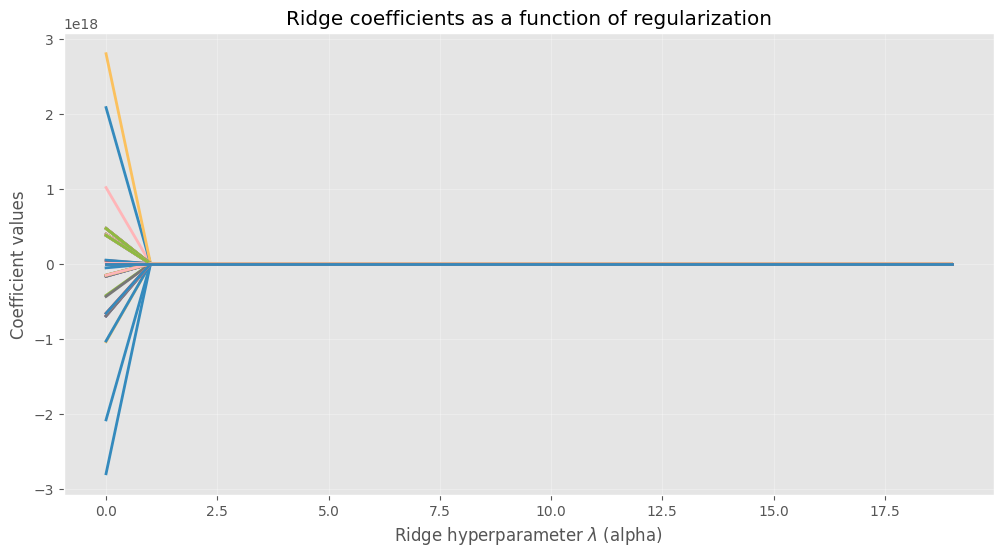

In [34]:
ridge = Ridge()
scaler_Y = StandardScaler()
scaler_X = StandardScaler()
Y_scaled = Y  #scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()
X_numeric_scaled = pd.DataFrame(
    scaler_X.fit_transform(Ames[Numeric_cols]),
    columns=Numeric_cols,
    index=Ames.index
)
X_scaled = pd.concat([X_numeric_scaled, Ames_Optimal_Categorical_One_Hot], axis=1)

#Ridge regression coefficient paths
alphas_ridge = np.arange(0, 20, 1)
coefs_ridge = []
scores_ridge = []
for alpha in alphas_ridge:
    ridge.set_params(alpha=alpha)
    ridge.fit(X_scaled, Y_scaled)
    coefs_ridge.append(ridge.coef_)
    scores_ridge.append(ridge.score(X_scaled, Y_scaled))

#Convert to DataFrame
coefs_ridge = pd.DataFrame(coefs_ridge, index=alphas_ridge, columns=X_scaled.columns)
scores_ridge = pd.Series(scores_ridge, index=alphas_ridge)

#print(coefs.head())
print("\nR^2 scores:\n", scores_ridge.head())

#Plot Ridge coefficient paths
plt.rcParams['figure.figsize'] = (12,6)
for name in coefs_ridge.columns:
    plt.plot(coefs_ridge.index, coefs_ridge[name], label=name, lw=2)
plt.xlabel(r'Ridge hyperparameter $\lambda$ (alpha)')
plt.ylabel('Coefficient values')
plt.title('Ridge coefficients as a function of regularization')
#plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

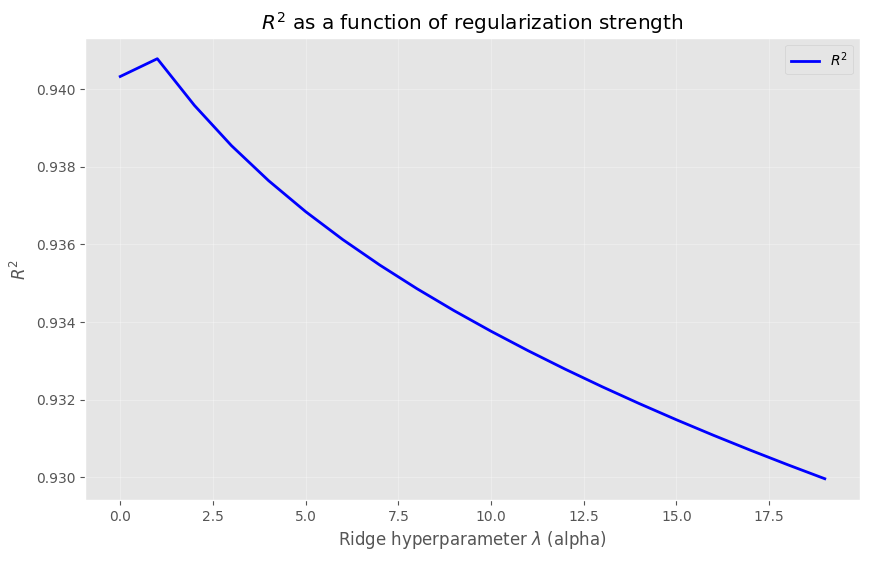

In [35]:
plt.figure(figsize=(10,6))
plt.plot(alphas_ridge, scores_ridge, c='b', lw=2, label=r'$R^2$')
plt.xlabel(r'Ridge hyperparameter $\lambda$ (alpha)')
plt.ylabel(r'$R^2$')
plt.title(r'$R^2$ as a function of regularization strength')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.show()

In [36]:
alphas_ridge = np.logspace(-5, 3, 100)
train_scores_ridge = []
test_scores_ridge = []
kf = KFold(n_splits=5, shuffle=True, random_state=2)

for alpha in alphas_ridge:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, Y_scaled)
    train_scores_ridge.append(ridge.score(X_scaled, Y_scaled))
    cv_score_ridge = cross_val_score(ridge, X_scaled, Y_scaled, cv=kf, scoring='r2')
    test_scores_ridge.append(cv_score_ridge.mean())

train_scores_ridge = np.array(train_scores_ridge)
test_scores_ridge = np.array(test_scores_ridge)
alpha_opt_ridge = alphas_ridge[np.argmin(np.abs(train_scores_ridge - test_scores_ridge))]
print('Optimal Ridge Alpha:', alpha_opt_ridge)

Optimal Ridge Alpha: 830.2175681319752


In [37]:
ridge.set_params(alpha=alpha_opt_ridge)
ridge.fit(X_scaled, Y_scaled)
# Coefficients as a Series with feature names
ridge_coefs = pd.Series(ridge.coef_, index=X_scaled.columns)
ridge.score(X_scaled, Y_scaled)
# --- Largest coefficients (absolute value) ---

#R² on the training data ---
cv_score_ridge = cross_val_score(ridge, X_scaled, Y_scaled, cv=kf, scoring='r2')
print(f"\nMean R²: {cv_score_ridge.mean():.4f};  ", f"Fold R² scores: {', '.join([f'{s:.4f}' for s in cv_score_ridge])}")

ridge_coefs_formatted = ridge_coefs.sort_values(key=abs, ascending=False)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print("Top 20 largest coefficients (by absolute value):")
print(ridge_coefs_formatted.head(20))

# --- Features with zero coefficients ---
zero_coefs_ridge = ridge_coefs[ridge_coefs == 0].index.tolist()
print(f"\nNumber of features with zero coefficient: {len(zero_coefs_ridge)}")
print("Zero coefficient features:")
print(zero_coefs_ridge)


Mean R²: 0.8587;   Fold R² scores: 0.8704, 0.8651, 0.8132, 0.8617, 0.8833
Top 20 largest coefficients (by absolute value):
GrLivArea        11108.0459
TotalBsmtSF       8784.9396
1stFlrSF          8132.7923
BsmtFinSF1        7073.5366
MasVnrArea        6571.3179
BsmtQual_5        5682.7913
KitchenQual_4     5654.7788
2ndFlrSF          5634.7344
YearRemodAdd      5256.1280
Fireplaces        5128.3149
GarageArea        5084.1562
TotRmsAbvGrd      4622.6998
KitchenQual_2    -4425.5540
ExterQual_1      -4416.0737
ExterQual_3       4223.4775
KitchenAbvGr     -4174.5313
YearBuilt         3914.4971
OverallQual_8     3852.6906
BsmtExposure_4    3815.2892
GarageCars        3718.0920
dtype: float64

Number of features with zero coefficient: 0
Zero coefficient features:
[]


In [23]:
# --- Lasso coefficient paths ---
lasso = Lasso(max_iter=10000)
alphas_lasso = np.arange(0.01, 5, .01)  # Lasso alpha must be >0
coefs_lasso = []
scores_lasso = []

for alpha in alphas_lasso:
    lasso.set_params(alpha=alpha)
    lasso.fit(X_scaled, Y_scaled)
    coefs_lasso.append(lasso.coef_)
    scores_lasso.append(lasso.score(X_scaled, Y_scaled))

coefs_lasso = pd.DataFrame(coefs_lasso, index=alphas_lasso, columns=X_scaled.columns)
scores_lasso = pd.Series(scores_lasso, index=alphas_lasso)

print("\nR^2 scores:\n", scores_lasso.head())


R^2 scores:
 0.0100   0.8815
0.0200   0.8601
0.0300   0.8442
0.0400   0.8278
0.0500   0.8168
dtype: float64


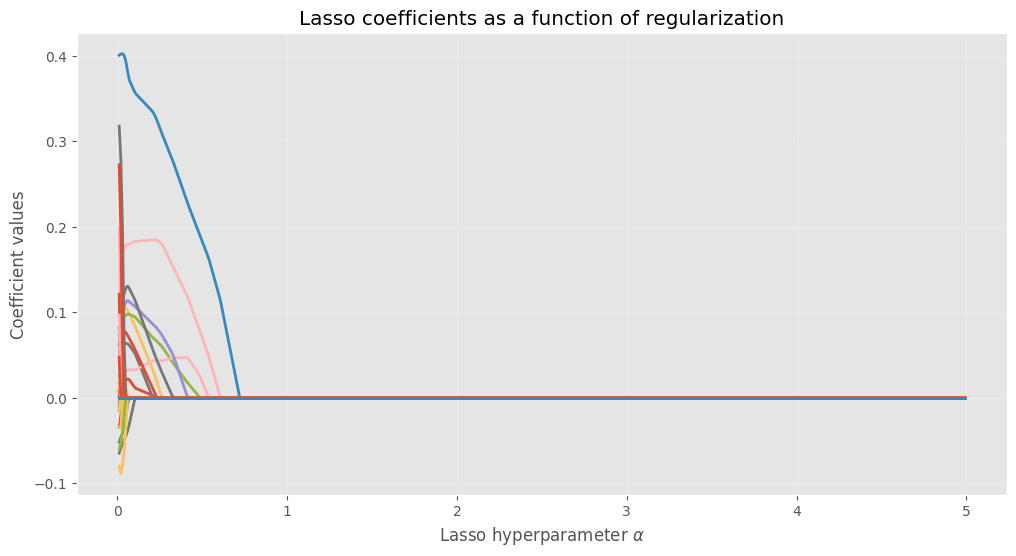

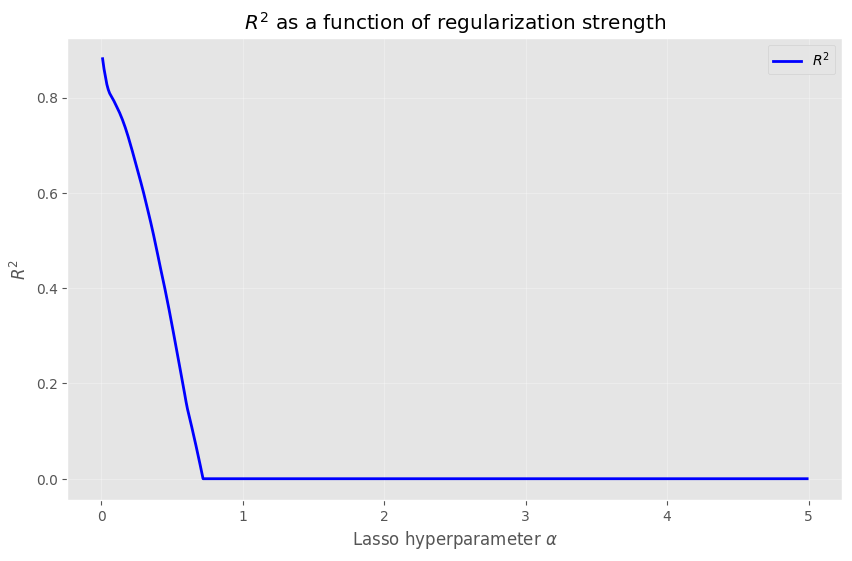

In [24]:
# --- Plot coefficient paths ---
plt.figure(figsize=(12,6))
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], lw=2)
plt.xlabel(r'Lasso hyperparameter $\alpha$')
plt.ylabel('Coefficient values')
plt.title('Lasso coefficients as a function of regularization')
plt.grid(alpha=0.3)
plt.show()

# --- Plot R^2 ---
plt.figure(figsize=(10,6))
plt.plot(alphas_lasso, scores_lasso, c='b', lw=2, label=r'$R^2$')
plt.xlabel(r'Lasso hyperparameter $\alpha$')
plt.ylabel(r'$R^2$')
plt.title(r'$R^2$ as a function of regularization strength')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.show()

In [39]:
#Cross-validated optimal alpha
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

kf = KFold(n_splits=5, shuffle=True, random_state=2)
lasso_cv = LassoCV(alphas=np.linspace(.0003, .0005, 1000), cv=kf, n_jobs=-1, max_iter=50000)
lasso_cv.fit(X_scaled, Y_scaled)

alpha_opt_lasso = lasso_cv.alpha_
print(f"Optimal Lasso Alpha: {alpha_opt_lasso:.4f}")

KeyboardInterrupt: 

In [26]:
#Fit Lasso with optimal alpha
lasso = Lasso(alpha=alpha_opt_lasso, max_iter=10000)
lasso.fit(X_scaled, Y_scaled)

lasso_coefs = pd.Series(lasso.coef_, index=X_scaled.columns)
lasso_coefs_formatted = lasso_coefs.sort_values(key=abs, ascending=False)
pd.set_option('display.float_format', lambda x: f'{x:.100f}')

#Scores & Coefficients
cv_scores_lasso = cross_val_score(lasso, X_scaled, Y_scaled, cv=kf, scoring='r2')
print(f"\nMean R² Scores: {cv_scores_lasso.mean():.4f};  ", f"Fold R² scores: {', '.join([f'{s:.4f}' for s in cv_scores_lasso])}")

print("\nTop 20 largest coefficients (by absolute value):")
print(lasso_coefs_formatted.head(20))

#Summary of zero coefficients
zero_coefs_lasso = lasso_coefs[lasso_coefs == 0].index.tolist()
non_zero_coefs_lasso = lasso_coefs[~lasso_coefs.index.isin(zero_coefs_lasso)]
print(f"\nNumber of features with Non-Zero coefficient: {len(non_zero_coefs_lasso)}")
print(f"\nNumber of features with Zero coefficient: {len(zero_coefs_lasso)}")
print("Zero coefficient features:")
print(zero_coefs_lasso)


Mean R² Scores: 0.9097;   Fold R² scores: 0.9096, 0.9371, 0.8375, 0.9322, 0.9321

Top 20 largest coefficients (by absolute value):
Condition2_PosN         -1.56293822355007239188751100300578400492668151...
Neighborhood_GrnHill    1.089889334933929809778874187031760811805725097...
OverallQual_9           1.016680455979364516849727806402370333671569824...
OverallQual_8           0.667757119055788939121498515305574983358383178...
RoofMatl_WdShngl        0.506275254307217870142210358608281239867210388...
PoolQC_4                0.502862534035291686151936119131278246641159057...
Neighborhood_StoneBr    0.446228212574420690650356391415698453783988952...
Neighborhood_NoRidge    0.359500910750075231003819453690084628760814666...
GrLivArea               0.340035980049607722275339938278193585574626922...
SaleCondition_Partial   0.287366102698908554291534755975590087473392486...
OverallQual_7           0.282401098271079564749896917419391684234142303...
OverallCond_1           -0.2822923376331237

In [31]:
#Best hyperparameters found by ElasticNetCV
elastic_cv = ElasticNetCV(
    l1_ratio=np.linspace(.32, .34, 10),
    alphas=np.linspace(.0007, .0009, 100),
    cv=5, max_iter=5000, n_jobs=-1
)
elastic_cv.fit(X_scaled, Y_scaled)
best_alpha_elastic = elastic_cv.alpha_
best_l1_elastic = elastic_cv.l1_ratio_
print(f"Optimal ElasticNet Alpha: {best_alpha_elastic:.4f}")
print(f"Optimal ElasticNet l1_ratio: {best_l1_elastic:.2f}")

#Build final ElasticNet model using best parameters
final_en = ElasticNet(alpha=best_alpha_elastic, l1_ratio=best_l1_elastic, max_iter=10000)
final_en.fit(X_scaled, Y_scaled)

#Scires
cv_scores_elasticnet = cross_val_score(final_en, X_scaled, Y_scaled, cv=kf, scoring='r2')
print(f"Mean CV R²: {cv_scores_elasticnet.mean():.4f};  ", f"Fold R² scores: {', '.join([f'{s:.4f}' for s in cv_scores_elasticnet])}\n")

#Coefficient Series
zero_features_elastic = coef_elastic[coef_elastic == 0].index.tolist()
nonzero_features_elastic = coef_elastic[coef_elastic != 0]

coef_elastic = pd.Series(final_en.coef_, index=X_scaled.columns)
top20_elastic = nonzero_features_elastic.reindex(nonzero_features_elastic.abs().sort_values(ascending=False).index).head(20)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print("Top 20 largest non-zero coefficients (abs, 4 decimals):")
print(top20_elastic)

#---Zero Coefficients
print(f"\nNumber of features with Non-Zero coefficient: {len(nonzero_features_elastic)}")
print(f"\nNumber of features with Zero coefficient: {len(zero_features_elastic)}")
print("Zero coefficient features:")
print(zero_features_elastic)

Optimal ElasticNet Alpha: 0.0008
Optimal ElasticNet l1_ratio: 0.33
Mean CV R²: 0.9116;   Fold R² scores: 0.9156, 0.9357, 0.8400, 0.9312, 0.9356

Top 20 largest non-zero coefficients (abs, 4 decimals):
Condition2_PosN         -1.0431
OverallQual_9            0.8343
Neighborhood_GrnHill     0.6971
OverallQual_8            0.5371
RoofMatl_WdShngl         0.4606
Neighborhood_StoneBr     0.4062
PoolQC_4                 0.3843
Neighborhood_NoRidge     0.3176
GrLivArea                0.3113
Condition2_PosA          0.3023
SaleCondition_Partial    0.2726
OverallCond_8            0.2660
OverallCond_1           -0.2656
OverallCond_2           -0.2490
ExterQual_3              0.2438
BldgType_Twnhs          -0.2303
Neighborhood_Somerst     0.2067
Exterior1st_BrkFace      0.2049
Neighborhood_NridgHt     0.2005
OverallCond_7            0.1996
dtype: float64

Number of features with Non-Zero coefficient: 197

Number of features with Zero coefficient: 99
Zero coefficient features:
['BsmtUnfSF', 'Alley

In [33]:
#Best hyperparameters found by ElasticNetCV where Rho = .5
elastic5_cv = ElasticNetCV(
    l1_ratio=.5,
    alphas=np.linspace(0, .001, 1000),
    cv=5,
    max_iter=5000,
    n_jobs=-1
)
elastic5_cv.fit(X_scaled, Y_scaled)

best_alpha_elastic5 = elastic5_cv.alpha_
best_l1_elastic5 = elastic5_cv.l1_ratio_
print(f"Optimal ElasticNet.5 Alpha: {best_alpha_elastic5:.4f}")
print(f"Optimal ElasticNet.5 l1_ratio: {best_l1_elastic5:.2f}")

#Build final ElasticNet model using best parameters
final_en = ElasticNet(alpha=best_alpha_elastic5, l1_ratio=best_l1_elastic5, max_iter=10000)
final_en.fit(X_scaled, Y_scaled)  #Fit final model

#Scores
cv_scores_elasticnet = cross_val_score(final_en, X_scaled, Y_scaled, cv=kf, scoring='r2')
print(f"Mean CV R²: {cv_scores_elasticnet.mean():.4f};  ", f"Fold R² scores: {', '.join([f'{s:.4f}' for s in cv_scores_elasticnet])}\n")

# Coefficients as a Series
coef_elastic5 = pd.Series(final_en.coef_, index=X_scaled.columns)

# Summary of coefficients
zero_features_elastic5 = coef_elastic5[coef_elastic5 == 0].index.tolist()
nonzero_features_elastic5 = coef_elastic5[coef_elastic5 != 0]

top20_elastic5 = nonzero_features_elastic5.reindex(nonzero_features_elastic5.abs().sort_values(ascending=False).index).head(20)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print("Top 20 largest non-zero coefficients (abs, 4 decimals):")
print(top20_elastic5)

#--Zero coefficients
print(f"\nNumber of features with Non-Zero coefficient: {len(nonzero_features_elastic5)}")
print(f"\nNumber of features with Zero coefficient: {len(zero_features_elastic5)}")
print("Zero coefficient features:")
print(zero_features_elastic5)

Optimal ElasticNet.5 Alpha: 0.0006
Optimal ElasticNet.5 l1_ratio: 0.50
Mean CV R²: 0.9111;   Fold R² scores: 0.9140, 0.9362, 0.8389, 0.9317, 0.9347

Top 20 largest non-zero coefficients (abs, 4 decimals):
Condition2_PosN         -1.2111
OverallQual_9            0.9237
Neighborhood_GrnHill     0.8234
OverallQual_8            0.6107
RoofMatl_WdShngl         0.4805
PoolQC_4                 0.4304
Neighborhood_StoneBr     0.4230
GrLivArea                0.3400
Neighborhood_NoRidge     0.3350
Condition2_PosA          0.2911
SaleCondition_Partial    0.2785
OverallCond_1           -0.2759
OverallCond_8            0.2680
OverallQual_7            0.2486
OverallCond_2           -0.2477
ExterQual_3              0.2401
BldgType_Twnhs          -0.2280
Neighborhood_Somerst     0.2214
Neighborhood_NridgHt     0.2112
OverallCond_7            0.2012
dtype: float64

Number of features with Non-Zero coefficient: 191

Number of features with Zero coefficient: 105
Zero coefficient features:
['1stFlrSF', 'B